In [96]:
# importando librerias
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import seaborn as sns


2. Keypoints using MP Holistic


In [97]:
mp_holistic = mp.solutions.holistic #Modelo Holistico
mp_drawing = mp.solutions.drawing_utils # Draw utilities dibuja puntos en la cada

4. Setup Folders for Collection


In [98]:
# Path for exported data, numpy arrays
DATA_PATH = r'C:\Users\METIC\Documents\GitHub\LSM\MP_Prueba1'

# Actions that we try to detect
actions = np.array(['Auxilio', 'Ayuda', 'Emergencia', 'Peligro', 'Urgente'])

# Thirty videos worth of data
no_sequences = 40

# Videos are going to be 30 frames in length
sequence_length = 30

6. Preprocess Data and Create Labels and Features


In [99]:
label_map = {label:num for num, label in enumerate(actions)}
label_map

{'Auxilio': 0, 'Ayuda': 1, 'Emergencia': 2, 'Peligro': 3, 'Urgente': 4}

In [100]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [101]:
np.array(sequences).shape

(200, 30, 1662)

In [102]:
np.array(labels).shape

(200,)

In [103]:
X = np.array(sequences)

In [104]:
y = to_categorical(labels).astype(int)

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [106]:
y_test.shape

(10, 5)

7. Build and Train LSTM Neural Network


In [107]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [108]:
print(X.shape)

(200, 30, 1662)


In [109]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='tanh', input_shape=(30, 1662)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(LSTM(32, return_sequences=False, activation='tanh'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(5, activation='softmax'))  #5 clases


c:\Users\METIC\anaconda3\envs\LSMenv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [110]:
res = [0.2, 0.2, 0.1, 0.2, 0.3]
actions[np.argmax(res)]

'Urgente'

In [111]:
opt = Adam(learning_rate=0.00005)  # más alto, ideal para datos pocos
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=500, batch_size=16, 
                    validation_split=0.2, callbacks=[early_stop])


Epoch 1/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - categorical_accuracy: 0.1823 - loss: 2.2663 - val_categorical_accuracy: 0.1053 - val_loss: 1.6322
Epoch 2/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - categorical_accuracy: 0.2189 - loss: 2.0641 - val_categorical_accuracy: 0.1053 - val_loss: 1.6184
Epoch 3/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - categorical_accuracy: 0.3253 - loss: 1.7511 - val_categorical_accuracy: 0.1316 - val_loss: 1.6089
Epoch 4/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - categorical_accuracy: 0.4434 - loss: 1.5451 - val_categorical_accuracy: 0.2632 - val_loss: 1.6027
Epoch 5/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - categorical_accuracy: 0.4188 - loss: 1.4540 - val_categorical_accuracy: 0.2105 - val_loss: 1.6013
Epoch 6/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - categorical_accuracy: 0.4463 - loss: 1.4663 - val_categorical_accuracy: 0.2368 - val_loss: 1.5891
Epoch 7/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - categorical_accuracy: 0.4287 - los

In [112]:
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 30, 64)         │       442,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 30, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,368,017 (5.22 MB)

 Trainable params: 455,941 (1.74 MB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 911,884 (3.48 MB)

8. Make Predictions


In [113]:

res = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


In [114]:
print(res)
print(res.shape)

[[8.3651869e-03 9.6722031e-01 1.1814662e-03 1.5656564e-02 7.5764731e-03]
 [9.8612887e-01 4.1413172e-03 5.1098843e-03 1.3088109e-03 3.3110906e-03]
 [2.0012351e-02 2.4857463e-02 9.2544270e-01 1.3168171e-02 1.6519271e-02]
 [1.2904020e-02 2.7177982e-02 1.4529407e-01 8.0806768e-01 6.5561682e-03]
 [1.1181838e-02 4.1993782e-02 7.7205732e-02 5.1911543e-03 8.6442745e-01]
 [1.5829010e-02 1.5729915e-02 7.1455920e-03 3.5306616e-03 9.5776480e-01]
 [8.4135629e-02 2.7622923e-01 1.7417689e-01 1.4940681e-01 3.1605145e-01]
 [3.0618139e-02 6.2601365e-02 3.1516660e-02 8.7106115e-01 4.2027347e-03]
 [9.9348760e-01 1.5057939e-03 3.7664380e-03 3.4798463e-04 8.9217583e-04]
 [4.4347506e-02 3.4570643e-01 1.3411111e-01 2.7508941e-01 2.0074558e-01]]
(10, 5)


In [115]:
actions[np.argmax(res[2])] ##originalmente era 4

'Emergencia'

In [116]:
actions[np.argmax(y_test[2])]

'Emergencia'

9. Save Weights


In [117]:
model.save('Prueba1.h5')
del model

In [118]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='tanh', input_shape=(30, 1662)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(LSTM(32, return_sequences=False, activation='tanh'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(5, activation='softmax')) 

In [119]:
opt = Adam(learning_rate=0.00005)  # más alto, ideal para datos pocos
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [120]:
model.load_weights('Prueba1.h5')

10. Evaluation using Confusion Matrix and Accuracy


In [121]:
yhat = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


In [122]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [123]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[8, 0],
        [0, 2]],

       [[8, 1],
        [0, 1]],

       [[9, 0],
        [0, 1]],

       [[7, 0],
        [1, 2]],

       [[6, 1],
        [1, 2]]], dtype=int64)

In [124]:
accuracy_score(ytrue, yhat)

0.8

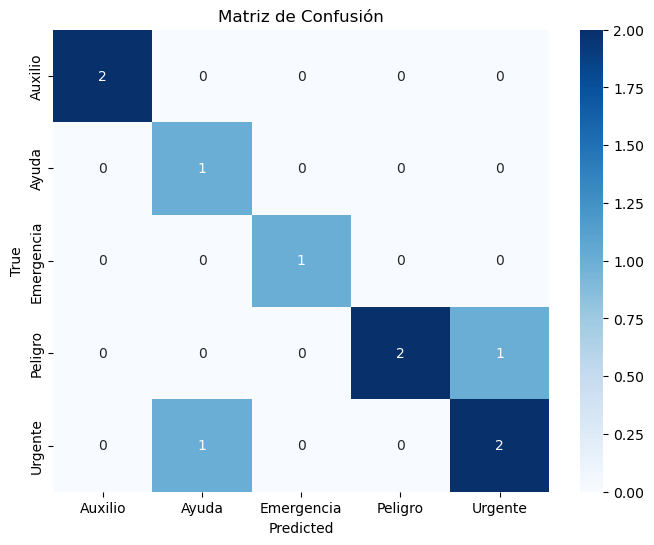

In [125]:
cm = confusion_matrix(ytrue, yhat)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=actions, yticklabels=actions)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusión')
plt.show()